# MCP Server with LangGraph Documentation

## Overview
This notebook demonstrates how to build AI agents using **LangGraph** with tool calling capabilities, progressing from synchronous to asynchronous workflows, and finally integrating with **Model Context Protocol (MCP)** servers.

---

## Table of Contents
1. [Introduction](#introduction)
2. [Main Topics Covered](#main-topics-covered)
3. [Prerequisites](#prerequisites)
4. [Section 1: Synchronous LangGraph with Custom Tools](#section-1-synchronous-langgraph-with-custom-tools)
5. [Section 2: Asynchronous Workflow](#section-2-asynchronous-workflow)
6. [Section 3: MCP Server Integration](#section-3-mcp-server-integration)
7. [Key Learnings](#key-learnings)
8. [Common Issues and Solutions](#common-issues-and-solutions)
9. [Best Practices](#best-practices)
10. [Next Steps](#next-steps)

---

## Introduction

This notebook explores building intelligent conversational agents that can use tools to perform tasks. It demonstrates three progressively advanced implementations:

1. **Basic synchronous tool-calling agent** with custom tools
2. **Asynchronous agent** for better performance
3. **MCP-integrated agent** that can connect to multiple servers (local and remote)

---

## Main Topics Covered

### 1. LangGraph Framework
- Building stateful conversation graphs
- Managing message history with `add_messages`
- Defining nodes and edges in a graph
- Conditional routing based on tool calls

### 2. Tool Integration
- Creating custom tools with `@tool` decorator
- Binding tools to LLMs
- Using `ToolNode` for automatic tool execution
- Handling tool responses

### 3. State Management
- Defining `ChatState` with TypedDict
- Using `Annotated` types for state reduction
- Message accumulation patterns

### 4. Asynchronous Programming
- Converting synchronous code to async
- Using `await` vs `asyncio.run()` in Jupyter notebooks
- Async invocation patterns with LangGraph

### 5. Model Context Protocol (MCP)
- Connecting to local MCP servers (stdio transport)
- Connecting to remote MCP servers (HTTP/SSE transport)
- Using `MultiServerMCPClient` to manage multiple servers
- Adapting MCP tools for LangChain compatibility

### 6. LLM Provider Integration
- Using Groq's ChatGroq for fast inference
- Handling API-specific requirements (tool message formatting)

---

## Prerequisites

### Required Libraries
```python
langgraph
langchain-core
langchain-groq
langchain-community
langchain-mcp-adapters
python-dotenv
fastmcp
```

### Environment Setup
- Python 3.13+
- Virtual environment configured
- `.env` file with API keys (GROQ_API_KEY, etc.)

---

## Section 1: Synchronous LangGraph with Custom Tools

### What's Demonstrated
This section shows how to build a basic LangGraph agent with a custom calculator tool.

### Key Components

#### 1. Tool Definition
```python
@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    # Implementation handles add, sub, mul, div operations
```

**Learning Point**: Tools must have clear docstrings - the LLM uses these to decide when to call the tool.

#### 2. LLM Configuration
```python
llm = ChatGroq(model='openai/gpt-oss-20b')
llm_with_tools = llm.bind_tools(tools)
```

**Learning Point**: `bind_tools()` gives the LLM awareness of available tools without requiring manual prompting.

#### 3. State Definition
```python
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
```

**Learning Point**: `add_messages` is a reducer function that automatically handles message accumulation, preventing duplicates and maintaining conversation history.

#### 4. Graph Construction
```python
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")
```

**Learning Point**: 
- `tools_condition` automatically determines if the LLM wants to call a tool
- The graph creates a loop: chat → tools → chat, allowing multiple tool calls
- This enables the agent to use tools iteratively to solve complex problems

#### 5. Execution
```python
chatbot = graph.compile()
result = chatbot.invoke({"messages": [HumanMessage(content="...")]})
```

### What You Learned
- ✅ How to create custom LangChain tools
- ✅ Building a stateful conversation graph
- ✅ Synchronous tool calling with automatic routing
- ✅ Message state management

---

## Section 2: Asynchronous Workflow

### Why Async?
Asynchronous programming allows:
- Better performance for I/O-bound operations (API calls)
- Non-blocking execution
- Concurrent operations
- Improved scalability

### Key Changes from Sync Version

#### 1. Async Node Definition
```python
async def chat_node(state: ChatState):
    messages = state["messages"]
    response = await llm_with_tools.ainvoke(messages)  # Note: ainvoke
    return {'messages': [response]}
```

**Learning Point**: Use `ainvoke()` instead of `invoke()` for async operations.

#### 2. Async Graph Building
```python
async def main():
    chatbot = build_graph()
    result = await chatbot.ainvoke({"messages": [...]})
```

#### 3. Jupyter-Specific Execution
```python
# ❌ DON'T use asyncio.run() in Jupyter
# asyncio.run(main())

# ✅ DO use await directly
await main()
```

**Critical Learning**: Jupyter notebooks already run in an event loop. Using `asyncio.run()` will cause:
```
RuntimeError: asyncio.run() cannot be called from a running event loop
```

### What You Learned
- ✅ Converting synchronous LangGraph to async
- ✅ Proper async/await patterns in Jupyter
- ✅ Difference between `invoke()` and `ainvoke()`
- ✅ Event loop management in notebooks

---

## Section 3: MCP Server Integration

### What is MCP?
**Model Context Protocol** is a standardized way to expose tools, resources, and prompts to LLMs. It allows:
- Connecting LLMs to external data sources
- Exposing APIs as tools
- Building modular, reusable tool servers
- Combining multiple tool providers

### Architecture Overview

```
┌─────────────────────────────────────────────┐
│          LangGraph Agent                     │
│  (ChatGroq + MultiServerMCPClient)           │
└─────────────────┬───────────────────────────┘
                  │
        ┌─────────┴──────────┐
        │                    │
┌───────▼────────┐  ┌────────▼──────────┐
│  Local MCP     │  │  Remote MCP       │
│  Server        │  │  Server           │
│  (stdio)       │  │  (HTTP/SSE)       │
│                │  │                   │
│  - add()       │  │  - add_expense()  │
│  - multiply()  │  │  - get_expenses() │
└────────────────┘  └───────────────────┘
```

### MCP Client Configuration

```python
client = MultiServerMCPClient(
    {
        "arith": {
            "transport": "stdio",
            "command": "/path/to/python",
            "args": ["/path/to/main.py"],
        },
        "expense": {
            "transport": "streamable_http",
            "url": "https://example.fastmcp.app/mcp"
        }
    }
)
```

**Learning Points**:
- **stdio transport**: Launches a local process, communicates via stdin/stdout
- **streamable_http transport**: Connects to HTTP-based MCP servers
- Use full path to Python executable to ensure correct virtual environment
- Each server gets a unique identifier ("arith", "expense")

### Dynamic Tool Loading

```python
async def build_graph():
    tools = await client.get_tools()  # Fetches tools from all servers
    print(f"Loaded tools: {[t.name for t in tools]}")
    llm_with_tools = llm.bind_tools(tools)
```

**Learning Point**: Tools are fetched dynamically at runtime, allowing flexible integration without hardcoding tool definitions.

### Groq API Compatibility Fix

```python
async def chat_node(state: ChatState):
    messages = state["messages"]
    
    # Fix tool message format for Groq
    for msg in messages:
        if msg.type == "tool" and not isinstance(msg.content, str):
            msg.content = json.dumps(msg.content)
    
    response = await llm_with_tools.ainvoke(messages)
    return {'messages': [response]}
```

**Critical Learning**: Different LLM providers have different requirements:
- **Groq** requires tool messages to have string content
- **MCP tools** often return structured objects or content arrays
- Solution: Convert complex tool outputs to JSON strings

### What You Learned
- ✅ Model Context Protocol fundamentals
- ✅ Connecting to local MCP servers (stdio)
- ✅ Connecting to remote MCP servers (HTTP)
- ✅ Managing multiple MCP servers simultaneously
- ✅ Handling LLM provider-specific formatting requirements
- ✅ Dynamic tool discovery and integration

---

## Key Learnings

### 1. **Graph-Based Agent Architecture**
LangGraph provides a powerful abstraction for building agents:
- **Nodes** represent operations (LLM calls, tool execution)
- **Edges** define control flow
- **Conditional edges** enable dynamic routing
- **State** maintains conversation context

### 2. **Tool Calling Patterns**
```
User Message → LLM (decides to use tool) → Tool Execution → LLM (uses result) → Final Response
```
This pattern can repeat multiple times in one conversation turn.

### 3. **Async is Essential for Production**
- Enables concurrent tool calls
- Better resource utilization
- Improved response times
- Scales better under load

### 4. **MCP Enables Modularity**
- Separate tool logic from agent logic
- Tools can be written in any language
- Easy to swap or upgrade tool providers
- Share tools across different agents/applications

### 5. **Provider-Specific Quirks**
Different LLM providers have different:
- Message format requirements
- Tool calling conventions
- Rate limits and performance characteristics

Always test with your specific provider and handle edge cases.

---

## Common Issues and Solutions

### Issue 1: `asyncio.run()` Error in Jupyter
**Error**: `RuntimeError: asyncio.run() cannot be called from a running event loop`

**Solution**: Use `await` directly instead of `asyncio.run()`
```python
# ❌ Wrong
asyncio.run(main())

# ✅ Correct
await main()
```

### Issue 2: Tool Message Format Error with Groq
**Error**: `BadRequestError: 'messages.2.content' : value must be a string`

**Solution**: Convert tool outputs to strings
```python
for msg in messages:
    if msg.type == "tool" and not isinstance(msg.content, str):
        msg.content = json.dumps(msg.content)
```

### Issue 3: MCP Server Not Found
**Error**: Server fails to start or connect

**Solutions**:
- Use absolute path to Python interpreter
- Verify virtual environment is activated
- Check that FastMCP server file exists
- Ensure all dependencies are installed in the correct environment

### Issue 4: Tools Not Being Called
**Possible Causes**:
- Tool description is unclear to the LLM
- Tool parameters don't match user request
- LLM decides the task doesn't require tools

**Solutions**:
- Write clear, specific tool docstrings
- Test with explicit requests ("use the calculator tool...")
- Check if LLM has general knowledge of the task

---

## Best Practices

### 1. Tool Design
- ✅ Write clear, concise tool descriptions
- ✅ Use type hints for all parameters
- ✅ Return consistent data structures
- ✅ Handle errors gracefully within tools
- ✅ Document supported operations/formats

### 2. State Management
- ✅ Use `add_messages` for automatic message accumulation
- ✅ Keep state minimal - only store what's needed
- ✅ Use TypedDict for type safety

### 3. Error Handling
- ✅ Wrap tool execution in try-except blocks
- ✅ Return informative error messages
- ✅ Log errors for debugging
- ✅ Provide fallback behavior when tools fail

### 4. Performance
- ✅ Use async for I/O-bound operations
- ✅ Consider caching tool results when appropriate
- ✅ Set reasonable timeouts for tool execution
- ✅ Monitor API rate limits

### 5. MCP Integration
- ✅ Use separate MCP servers for different domains
- ✅ Version your MCP servers
- ✅ Document tool schemas clearly
- ✅ Test MCP servers independently before integration

---

## Next Steps

### Immediate Enhancements
1. **Add more tools** to your MCP servers
2. **Implement streaming** for real-time responses
3. **Add memory/persistence** to maintain conversation history across sessions
4. **Error recovery** - handle tool failures gracefully

### Advanced Topics to Explore
1. **LangGraph Checkpointing** - Save and resume agent state
2. **Human-in-the-loop** - Add approval steps for sensitive operations
3. **Multi-agent systems** - Coordinate multiple specialized agents
4. **Custom routing logic** - Build sophisticated decision trees
5. **Tool result validation** - Verify tool outputs before using them
6. **Parallel tool execution** - Run independent tools concurrently

### Production Considerations
1. **Authentication & Authorization** for MCP servers
2. **Rate limiting** and quota management
3. **Monitoring & observability** - Track tool usage, latency, errors
4. **Testing** - Unit tests for tools, integration tests for graphs
5. **Deployment** - Containerization, scaling strategies

---

## Resources

### Documentation
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangChain Tools](https://python.langchain.com/docs/modules/agents/tools/)
- [Model Context Protocol Spec](https://modelcontextprotocol.io/)
- [FastMCP Library](https://github.com/jlowin/fastmcp)

### Related Notebooks in This Repository
- `simple_graph_bot.ipynb` - Basic graph concepts
- `sequential_flow.ipynb` - Sequential agent workflows
- `parallel_workflow.ipynb` - Parallel execution patterns
- `iterative_workflow.ipynb` - Iterative problem solving
- `persistence.ipynb` - State persistence

---

## Summary

This notebook demonstrated the evolution from simple tool-calling agents to sophisticated MCP-integrated systems:

1. **Started with basics**: Custom tools + LangGraph
2. **Added performance**: Async workflows
3. **Achieved modularity**: MCP server integration

The final implementation shows a production-ready pattern for building agents that can:
- Use multiple tool sources
- Work with any MCP-compatible server
- Handle complex, multi-step tasks
- Scale efficiently with async execution

The MCP integration pattern is particularly powerful because it allows you to:
- Build tools once, use everywhere
- Share tools across teams and projects
- Integrate third-party tool providers
- Keep agent logic separate from tool implementation

This architecture is ready for real-world applications! 🚀


In [13]:
from langgraph.graph import StateGraph,START
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_classic.tools import DuckDuckGoSearchRun
from langgraph.graph.message import add_messages,BaseMessage
from langchain_core.messages import HumanMessage
from langchain_classic.tools import tool
from typing import Annotated,TypedDict
from langgraph.prebuilt import ToolNode,tools_condition
load_dotenv()
llm= ChatGroq(model='openai/gpt-oss-20b',)



In [3]:
@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

In [4]:
tools=[calculator]
llm_with_tools=llm.bind_tools(tools)

In [9]:
class ChatState(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [10]:
def chat_node(state=ChatState):
    messages=state["messages"]
    response=llm_with_tools.invoke(messages)
    return {"messages":[response]}

tool_node=ToolNode(tools)


In [11]:
graph=StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

# defining graph connections
graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")


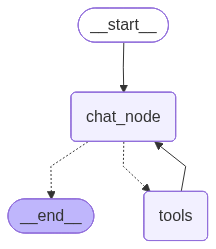

In [16]:
chatbot = graph.compile()
chatbot

In [17]:


# running the graph
result = chatbot.invoke({"messages": [HumanMessage(content="Find the modulus of 132354 and 23 and give answer like a cricket commentator.")]})

print(result['messages'][-1].content)

🎙️ **Cricket Commentary Voice** 🎙️

"All right, folks, we’re at the finish line of this thrilling mathematical innings! The batsman, 132,354, has faced a daunting bowling attack of 23 overs. The bowler’s delivery? A perfect 23. And what a run! The batsman scores a massive 132,354 runs, but the scoreboard’s not finished yet. 

Now, the crowd is on the edge of their seats as we calculate the final tally. 23 goes into 132,354 exactly 5,754 times, but there’s a tiny bit of runs left on the field. After all the overs are bowled, the final count on the scoreboard shows a **remainder of 12 runs**. 

So there you have it, a crisp 12 runs left on the board, and that’s the final score of this mathematical match! 🏏✨


In [18]:
print(result)

{'messages': [HumanMessage(content='Find the modulus of 132354 and 23 and give answer like a cricket commentator.', additional_kwargs={}, response_metadata={}, id='65a6bf30-2178-402c-9577-39ea5fb9c0b0'), AIMessage(content='🎙️ **Cricket Commentary Voice** 🎙️\n\n"All right, folks, we’re at the finish line of this thrilling mathematical innings! The batsman, 132,354, has faced a daunting bowling attack of 23 overs. The bowler’s delivery? A perfect 23. And what a run! The batsman scores a massive 132,354 runs, but the scoreboard’s not finished yet. \n\nNow, the crowd is on the edge of their seats as we calculate the final tally. 23 goes into 132,354 exactly 5,754 times, but there’s a tiny bit of runs left on the field. After all the overs are bowled, the final count on the scoreboard shows a **remainder of 12 runs**. \n\nSo there you have it, a crisp 12 runs left on the board, and that’s the final score of this mathematical match! 🏏✨', additional_kwargs={'reasoning_content': 'We need to fi

### same code in async  

In [21]:
from langgraph.graph import StateGraph,START
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_classic.tools import DuckDuckGoSearchRun
from langgraph.graph.message import add_messages,BaseMessage
from langchain_core.messages import HumanMessage
from langchain_classic.tools import tool
from typing import Annotated,TypedDict
from langgraph.prebuilt import ToolNode,tools_condition
import asyncio

load_dotenv()  # Load environment variables from .env file

llm= ChatGroq(model='openai/gpt-oss-20b',)

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

tools = [calculator]

llm_with_tools = llm.bind_tools(tools)

# state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


def build_graph():

    # nodes
    async def chat_node(state: ChatState):

        messages = state["messages"]
        response = await llm_with_tools.ainvoke(messages)
        return {'messages': [response]}

    tool_node = ToolNode(tools)

    # defining graph and nodes
    graph = StateGraph(ChatState)

    graph.add_node("chat_node", chat_node)
    graph.add_node("tools", tool_node)

    # defining graph connections
    graph.add_edge(START, "chat_node")
    graph.add_conditional_edges("chat_node", tools_condition)
    graph.add_edge("tools", "chat_node")

    chatbot = graph.compile()

    return chatbot

async def main():

    chatbot = build_graph()

    # running the graph
    result = await chatbot.ainvoke({"messages": [HumanMessage(content="Find the modulus of 132354 and 23 and give answer like a cricket commentator.")]})

    print(result['messages'][-1].content)

# In Jupyter notebooks, the event loop is already running.
# Useing  await main() instead of asyncio.run(main())
await main()

**Commentator**: *"And here we go, folks! The ball’s rolling down the pitch, the bat’s swinging, the crowd’s roaring. We’re heading into the final over of this thrilling mathematical match. The bowler—well, our trusty calculator—delivers the ball: 132,354 is the bat’s number, and 23 is the wicket keeper’s number. The ball arcs, the fielders spread out, and the ball—ah! It hits the boundary! The wicket keeper dives, but the ball slips through. The batsman—our number 132,354—runs, and the fielding side—23—tries to take the catch. They’re out! The final count: the remainder is 12. Yes, 12! And that’s the wicket! A spectacular finish, and the modulus of 132,354 by 23 is a crisp 12. What a delivery!"}


In [28]:
from langgraph.graph import StateGraph,START
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph.message import add_messages,BaseMessage
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from typing import Annotated,TypedDict
from langgraph.prebuilt import ToolNode,tools_condition
import asyncio
import json

from langchain_mcp_adapters.client import MultiServerMCPClient


load_dotenv()  # Load environment variables from .env file

llm= ChatGroq(model='openai/gpt-oss-20b',)

# MCP client for local FastMCP server
client = MultiServerMCPClient(
    {
        "arith": {
            "transport": "stdio",
            "command": "/Users/owner/Desktop/Agentic-AI/graphvenv/bin/python",          
            "args": ["/Users/owner/Desktop/Agentic-AI/main.py"],
        },
        "expense": {
            "transport": "streamable_http",  # if this fails, try "sse"
            "url": "https://splendid-gold-dingo.fastmcp.app/mcp"
        }
    }
)


# state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


async def build_graph():

    tools = await client.get_tools()

    print(f"Loaded tools: {[t.name for t in tools]}")

    llm_with_tools = llm.bind_tools(tools)

    # nodes
    async def chat_node(state: ChatState):
        messages = state["messages"]
        
        # Groq is strict about tool message content. 
        # MCP tools often return a list of content blocks, which Groq may reject.
        # We ensure all tool messages have string content.
        for msg in messages:
            if msg.type == "tool" and not isinstance(msg.content, str):
                msg.content = json.dumps(msg.content)
        
        response = await llm_with_tools.ainvoke(messages)
        return {'messages': [response]}

    tool_node = ToolNode(tools)

    # defining graph and nodes
    graph = StateGraph(ChatState)

    graph.add_node("chat_node", chat_node)
    graph.add_node("tools", tool_node)

    # defining graph connections
    graph.add_edge(START, "chat_node")
    graph.add_conditional_edges("chat_node", tools_condition)
    graph.add_edge("tools", "chat_node")

    chatbot = graph.compile()

    return chatbot

async def main():

    chatbot = await build_graph()

    # running the graph
    result = await chatbot.ainvoke({"messages": [HumanMessage(content="Give me all my expenses for the month of Nov from 1 Nov to 30 Nov")]})

    print(result['messages'][-1].content)

if __name__ == '__main__':
    await main()

Loaded tools: ['add', 'multiply', 'add_expense', 'list_expenses', 'summarize']
It looks like there are no expense entries recorded for November 2024 (from 2024‑11‑01 to 2024‑11‑30). If you need to add any, just let me know and I can help you log them!
